# Baseline notebook for breast cancer detection, written in keras and Tensorflow.


In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
import pandas as pd, numpy as np, random, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import wandb
import yaml

from IPython import display as ipd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.preprocessing import minmax_scale
import random
import cv2
from imgaug import augmenters as iaa
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation

# Dataset
Using 256 processed dicom images to png

In [5]:
np.random.seed(10)

train_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

test_df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/test.csv')


base_path='/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_256/'

# saving image path into train dataframe
train_df['img_path']= f'{base_path}/train_images_processed_cv2_256'\
                    + '/' + train_df.patient_id.astype(str)\
                    + '/' + train_df.image_id.astype(str)\
                    + '.png'



display(train_df.head(3))

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/...


0    53548
1     1158
Name: cancer, dtype: int64


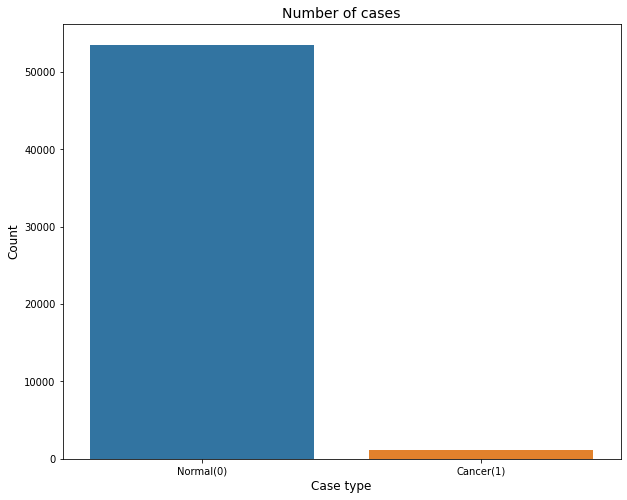

In [12]:
# Get the counts for each class
cases_count = train_df['cancer'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Cancer(1)'])
plt.show()

As you can see the data is highly imbalance where only 1158 of cancer cases and 53548 normal sample images.



# show some samples of cancer and normal cases
# 

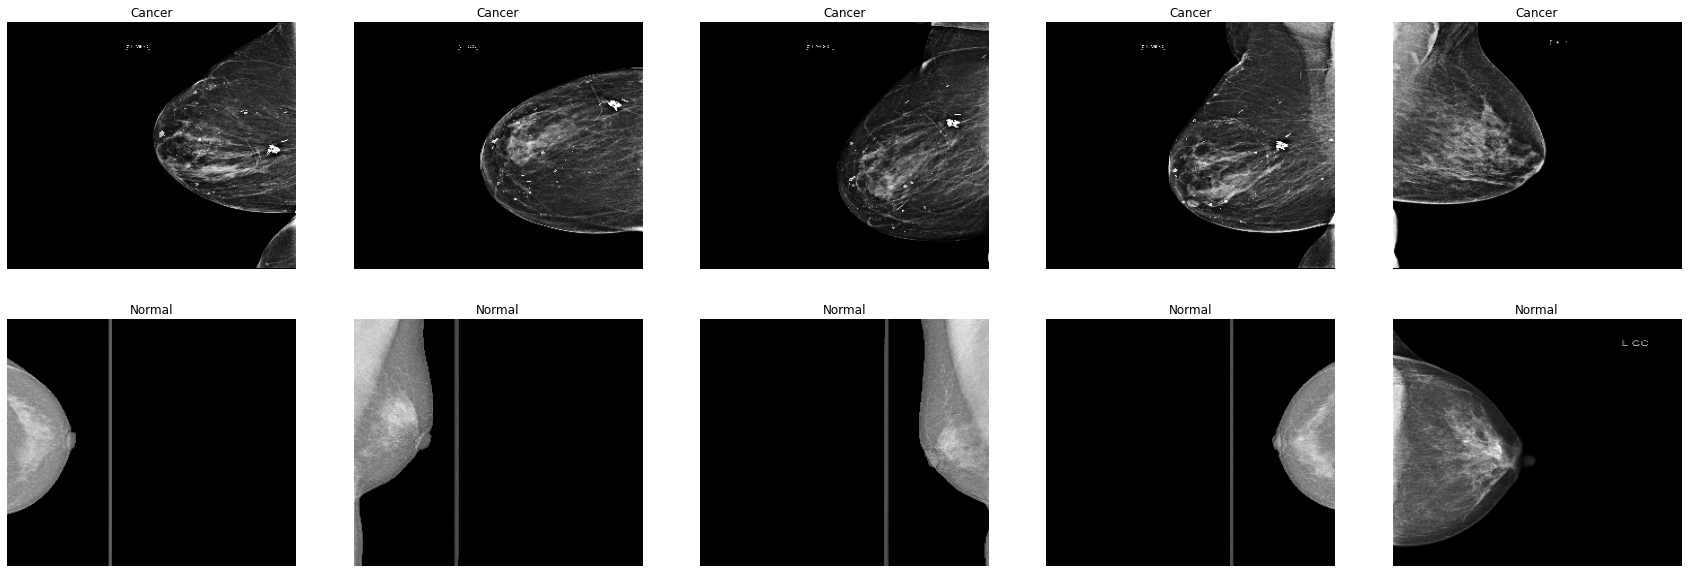

In [13]:
Cancer_samples = (train_df[train_df['cancer']==1]['img_path'].iloc[0:5]).tolist()
Normal_samples = (train_df[train_df['cancer']==0]['img_path'].iloc[0:5]).tolist()
# Concat the data in a single list and del the above two list
samples = Cancer_samples + Normal_samples
# source = "../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/"
# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = tf.keras.preprocessing.image.load_img(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Cancer")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

# Augmentation Functions
# 

In [14]:
data_augmentation_layers = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomCrop(height=256, width=256),
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomZoom((-0.2, 0)),
        layers.experimental.preprocessing.RandomContrast((0.2,0.2)),
])


# Show Augmentations


(1, 256, 256, 3)
augmented_image  (1, 256, 256, 3)
augmented_image  (1, 256, 256, 3)
augmented_image  (1, 256, 256, 3)
augmented_image  (1, 256, 256, 3)
augmented_image  (1, 256, 256, 3)
augmented_image  (1, 256, 256, 3)


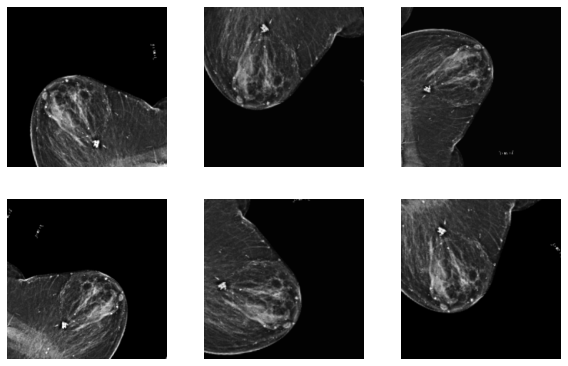

In [15]:
image = tf.keras.preprocessing.image.load_img(train_df['img_path'][90])

image = tf.expand_dims(np.array(image), 0)

print(image.shape)

plt.figure(figsize=(10, 10))
for i in range(6):
  augmented_image = data_augmentation_layers(image)
  print('augmented_image ',augmented_image.shape)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

# DataGenerator Class to generate batches of images and labels

In [17]:
from imgaug import augmenters as iaa



class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, path, batch_size=32, shuffle=True,aug=True,labels=True):
        self.df = df.copy()
        if 'prediction_id' not in df:
            self.df['prediction_id'] = df["patient_id"].astype(str) + '_' + df["laterality"].astype(str)

        self.prediction_ids = self.df['prediction_id'].unique()
        self.labels = labels
        if self.labels ==True:
            self.labels = self.df.groupby('prediction_id')['cancer'].max()
        self.path = path
        self.batch_size = batch_size
        self.aug=aug
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(len(self.prediction_ids) / self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data"""
        batch_indexes = self.prediction_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indexes)
        return X, y

    def __get_input(self, path):
        
#         print('path   ',path)
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        
        if self.aug:
             image_arr=self.augmentor(image_arr)

        return image_arr

    
    def augmentor(self, images):
        'Apply data augmentation'
        images=data_augmentation_layers(images)

        return images
    
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_indexes):
        paths = self.get_paths_images(batch_indexes)
        X = np.asarray([self.__get_input(path) for path in paths])
        y = np.array([self.labels[batch_indexes]])
        return X, y

    def get_paths_images(self, batch_indexes):
        batch = self.df[self.df['prediction_id'].isin(batch_indexes)]
        rows_batch = self.get_rows(batch)
        return self.path + rows_batch["patient_id"].astype(str) + "/" + rows_batch["image_id"].astype(
            str) + ".png"

    def get_rows(self, batch):
        """Select only 1 MLO view picture per breast"""
        only_MLO_view_images = batch[batch['view'] == 'MLO']
        only_one_per_prediction_id = only_MLO_view_images.groupby('prediction_id')[['patient_id', 'image_id']].max()
        return only_one_per_prediction_id

# Define Metrics


In [18]:
def weighted_binary_loss(weight, from_logits=True, reduction="mean"):
    def inverse_sigmoid(sigmoidal):
        return - tf.math.log(1. / sigmoidal - 1.)

    def weighted_loss(labels, predictions):
        predictions = tf.convert_to_tensor(predictions)
        labels = tf.cast(labels, predictions.dtype)
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)

        logits = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: predictions,
            lambda: inverse_sigmoid(sigmoidal=predictions),
        )
        loss = tf.nn.weighted_cross_entropy_with_logits(
            tf.cast(labels, dtype=tf.float32), logits, pos_weight=weight
        )
        
        if reduction.lower() == "mean":
            return tf.reduce_mean(loss)
        elif reduction.lower() == "sum":
            return tf.reduce_sum(loss) / num_samples
        elif reduction.lower() == "none":
            return loss
        else:
            raise ValueError(
                'Reduction type is should be `mean` or `sum` or `none`. ',
                f'But, received {reduction}'
            )
    return weighted_loss

def binary_focal_loss(
    alpha=0.25, 
    gamma=2.0, 
    label_smoothing=0, 
    from_logits=False,
    apply_class_balancing=False,
    apply_positive_weight=1,
    reduction="mean"
):
    '''
    alpha: A weight balancing factor for class 1, default is 0.25. 
        The weight for class 0 is 1.0 - alpha.
    
    gamma: A focusing parameter used to compute the focal factor, default is 2.0
    
    apply_class_balancing: A bool, whether to apply weight balancing on the binary 
        classes 0 and 1.
    '''
    
    def smooth_labels(labels):
        return labels * (1.0 - label_smoothing) + 0.5 * label_smoothing
    
    def compute_loss(labels, logits):
        logits = tf.convert_to_tensor(logits)
        labels = tf.cast(labels, logits.dtype)
        labels = tf.cond(
            tf.cast(label_smoothing, dtype=tf.bool),
            lambda: smooth_labels(labels),
            lambda: labels,
        )
        num_samples = tf.cast(tf.shape(labels)[-1], dtype=labels.dtype)
        cross_entropy = weighted_binary_loss(
            apply_positive_weight, from_logits, reduction='none'
        )(labels, logits)
        
        sigmoidal = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(logits),
            lambda: logits,
        )
        pt = labels * sigmoidal + (1.0 - labels) * (1.0 - sigmoidal)
        focal_factor = tf.pow(1.0 - pt, gamma)
        focal_bce =  focal_factor * cross_entropy
        
        if apply_class_balancing:
            weight = labels * alpha + (1 - labels) * (1 - alpha)
            focal_bce = weight * focal_bce

        if reduction == 'mean':
            return tf.reduce_mean(focal_bce)
        elif reduction == 'sum':
            return tf.reduce_sum(focal_bce) / num_samples
        else:
            raise ValueError(
                'Reduction type should be `mean` or `sum` ',
                f'But, received {reduction}'
            )
    return compute_loss

def tf_pfbeta(from_logits=True, beta=1.0, epsilon=1e-07):
    
    def pfbeta(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        ctp = tf.reduce_sum(y_true * y_pred, axis=-1)
        cfp = tf.reduce_sum(y_pred, axis=-1) - ctp

        c_precision = ctp / (ctp + cfp)
        c_recall = ctp / tf.reduce_sum(y_true)
        
        def compute_fractions():
            numerator = c_precision * c_recall
            denominator = beta**2 * c_precision + c_recall
            return (1 + beta**2) * tf.math.divide_no_nan(numerator, denominator)
        
        return tf.cond(
            tf.logical_and(
                tf.greater(c_precision, 0.), tf.greater(c_recall, 0.)
            ),
            compute_fractions,
            lambda: tf.constant(0, dtype=tf.float32)
        )
    
    return pfbeta

def tf_auc(from_logits=True):
    auc_fn = metrics.AUC()
    
    def auc(y_true, y_pred):
        y_pred = tf.cond(
            tf.cast(from_logits, dtype=tf.bool),
            lambda: tf.nn.sigmoid(y_pred),
            lambda: y_pred,
        )
        return auc_fn(y_true, y_pred)
    
    return auc

In [19]:
def get_lr_callback(batch_size=8,scheduler='cosine'):
    lr_start   = 0.000005
    lr_max     = 0.00000105  * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        elif scheduler=='exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        elif scheduler=='cosine':
            decay_total_epochs = CFG.epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.4 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
  
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback



# Baseline Model


In [20]:
import tensorflow as tf


def create_model(inp_dim=(256, 256, 3)):
    inputs = tf.keras.layers.Input(inp_dim)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', strides=4)(inputs)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    opti =  tf.keras.optimizers.Adam(lr=0.003,clipvalue=0.7)

    
    model.compile(
        optimizer = tfa.optimizers.RectifiedAdam(
            learning_rate=0.003, amsgrad=False
        ),
        loss = binary_focal_loss(
            apply_class_balancing=True, 
            apply_positive_weight=5,  
            alpha=0.65, 
            gamma=5.0,
            label_smoothing=0.01,
            from_logits=True,
            reduction='mean'
        ), 
        metrics = [
            tf_pfbeta(beta=1.0, from_logits=True),
            tf_auc(from_logits=True),
        ]
    )

    return model

# Function to generate train and validation batches
# 

In [21]:
import numpy as np
import pandas as pd

np.random.seed(0)

batch_size=8
epochs=2
img_path='/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_256/train_images_processed_cv2_256/'

def get_train_val_generator(train_size=0.8, batch_size=batch_size, filename=train_df, image_dir=img_path):

    patient_ids = train_df["patient_id"].unique()
    np.random.shuffle(patient_ids)
    train_size = int(len(patient_ids) * train_size)
    train_ids = patient_ids[:train_size]
    val_ids = patient_ids[train_size:]

    df_train = train_df[train_df['patient_id'].isin(train_ids)]
    df_val = train_df[train_df['patient_id'].isin(val_ids)]

    train_gen = DataGenerator(df_train, batch_size=batch_size, path=image_dir,aug=True)
    val_gen = DataGenerator(df_val, batch_size=batch_size, path=image_dir,aug=False)
    
    return train_gen, val_gen

In [ ]:
from tensorflow.keras import metrics

model = create_model()

image_dir = f'{base_path}/train_images_processed_cv2_256/'
dataset_path = train_df
train_gen, val_gen = get_train_val_generator(filename=dataset_path, image_dir=image_dir)


 
save_path='../'
val_pfbeta_weights=tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_pfbeta', mode='max', verbose=2, save_best_only=True, save_weights_only=True, period=1)

callbacks=[val_pfbeta_weights,get_lr_callback(batch_size=batch_size)]

train_gen, val_gen = get_train_val_generator(filename=dataset_path, image_dir=image_dir)      
history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,callbacks=callbacks)


Epoch 1/2
 791/2382 [========>.....................] - ETA: 9:12 - loss: 0.0178 - pfbeta: 0.0318 - auc: 0.4978

In [ ]:
# Test Images

DATASET_PATH='/kaggle/input/rsna-breast-cancer-detection/'
test_df = pd.read_csv(os.path.join(DATASET_PATH, "test.csv"))
display(test_df.head())
print(f'cases: {len(test_df)}')

# Show sample submission example

df_sub = pd.read_csv(os.path.join(DATASET_PATH, "sample_submission.csv"))
display(df_sub.head())
print(f'cases: {len(df_sub)}')

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, dtype = tf.float32)
    img = img/255.0
    return img

# test_paths=[]
# test_dir='/kaggle/input/rsnatest/test_images_256/10008/'
# img_path= os.listdir (test_dir)



DF_PATH = '/kaggle/input/rsna-breast-cancer-detection'
df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

test_path='/kaggle/input/rsnatest/test_images_256/'

test_dir = f'{test_path}'




test_df['img_path']= f'{test_dir}/'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.image_id.astype(str)\
                    + '.png'


test_df
# image = tf.keras.preprocessing.image.load_img(test_df['img_path'][1])
        
# plt.imshow(image)
# plt.show()

In [ ]:
preds=[]
for i in range (len(test_df['img_path'])):
    
    image = tf.keras.preprocessing.image.load_img(test_df['img_path'][i])

    image=tf.expand_dims(np.array(image), 0)
    pred=model.predict(np.asarray(image))
    
    preds.append(pred)

In [ ]:
pred_df = pd.DataFrame({'prediction_id':test_df.prediction_id,
                        'cancer':preds})

pred_df['cancer']=(pred_df.cancer > 0.5).astype(int)




In [ ]:
pred_df.to_csv('sample_submission.csv', index=False)